In [6]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import os
import json
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.ticker as ticker


In [7]:
## Validater reading and cleaning
path = '../EXAM/data/BM011_2023Q1_Denmark_Property_prices.csv'
BM011 = pd.read_csv(path,encoding='iso-8859-1',sep=';',skiprows=[1,2,4,5],header=1,usecols=[2,3,4,5])
BM011 = pd.DataFrame(BM011)

# Split out postal code
BM011[['postal_code','area_name']] = BM011[' .2'].str.split(' ',1,expand=True)
BM011 = BM011.drop([' .2','area_name'],axis=1)

# NaN value cleaning
BM011 = BM011.replace('..',0)

# Changing data type
BM011[['Detached/terraced house','Owner-occupied flat','Holiday home']] = BM011[['Detached/terraced house','Owner-occupied flat','Holiday home']].astype(float)
BM011 = BM011.set_index('postal_code',drop=True)

print(BM011.index)

Index(['1000-1499', '1500-1799', '1800-1999', '2000', '2100', '2150', '2200',
       '2300', '2400', '2450',
       ...
       '9830', '9850', '9870', '9881', '9900', '9940', '9970', '9981', '9982',
       '9990'],
      dtype='object', name='postal_code', length=605)


/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_88921/2684799627.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  BM011[['postal_code','area_name']] = BM011[' .2'].str.split(' ',1,expand=True)


In [8]:
## Validatee reading and cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# Regroup type
df['type'] = df['type'].replace({
    'land' : 'Holiday home',
    # 'Villa' : 'Holiday home',
    'Villa' : 'Detached/terraced house',
    'Apartment' : 'Owner-occupied flat',
    'Terraced house' : 'Detached/terraced house'
})

# Regroup area code
df['area_code'] = df['area_code'].astype(int)
for i in range(len(df['area_code'])):
    if df['area_code'][i] < 1500:
        df['area_code'][i] = '1000-1499'
    elif df['area_code'][i] < 1800:
        df['area_code'][i] ='1500-1799'
    elif df['area_code'][i] < 2000:
        df['area_code'][i] = '1800-1999'
df['area_code'] = df['area_code'].astype(str)


# Price per squared metre
df['price_per_m2'] = df['price'] / df['living_space']
# np.round(df[['price_per_m2','area_code','type']].pivot(index='area_code',columns='type',values=df['price_per_m2']).mean(),2)
# np.round(df[['price_per_m2','area_code','type']].groupby(['area_code','type']).mean(),2)
pivot = np.round(pd.pivot_table(df,values='price_per_m2',index='area_code',columns='type',aggfunc=np.mean),2)
pivot = pivot.fillna(0)
print(pivot.index)

Index(['1000-1499', '1500-1799', '1800-1999', '2000', '2100', '2150', '2200',
       '2300', '2400', '2450',
       ...
       '9830', '9850', '9870', '9881', '9900', '9940', '9970', '9981', '9982',
       '9990'],
      dtype='object', name='area_code', length=528)


/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_88921/4073834825.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_code'][i] = '1000-1499'


In [9]:
# Keep observations in BM011 in the same postal region of scraped data
BM011_f = BM011.loc[pivot.index]

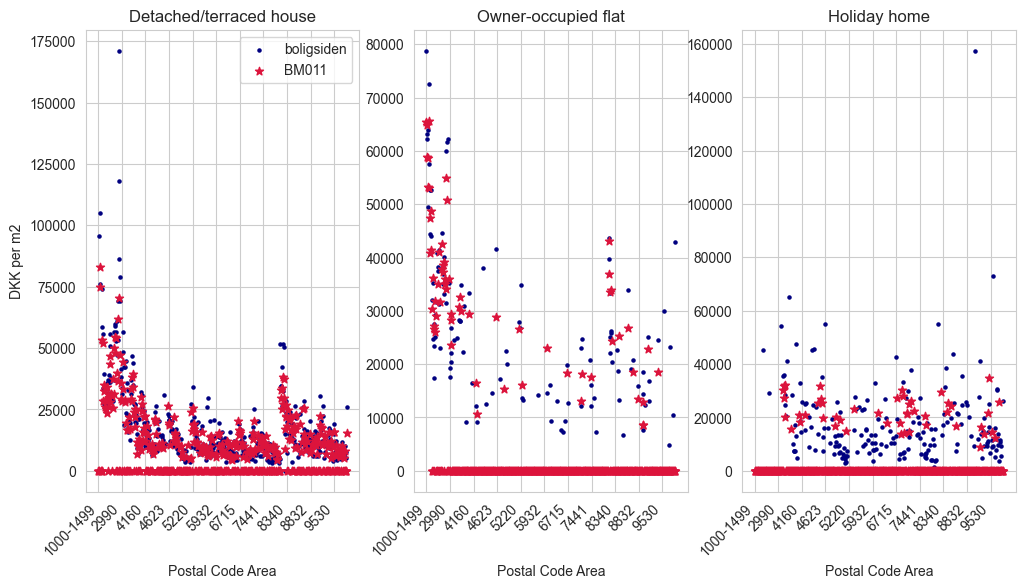

In [11]:
## Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Scrapped from boligsiden
axes[0].scatter(pivot.index, pivot['Detached/terraced house'], marker='o', color='navy', label='boligsiden', s=5)
axes[1].scatter(pivot.index, pivot['Owner-occupied flat'], marker='o', color='navy', label='boligsiden', s=5)
axes[2].scatter(pivot.index, pivot['Holiday home'], marker='o', color='navy', label='boligsiden', s=5)

# Downloaded from Finans Denmark
axes[0].scatter(pivot.index, BM011_f['Detached/terraced house'], color='crimson', marker='*', label='BM011')
axes[1].scatter(pivot.index, BM011_f['Owner-occupied flat'], marker='*', color='crimson')
axes[2].scatter(pivot.index, BM011_f['Holiday home'], marker='*', color='crimson')

# set title
axes[0].set_title('Detached/terraced house')
axes[1].set_title('Owner-occupied flat')
axes[2].set_title('Holiday home')

# set xlabel
axes[0].set_xlabel('Postal Code Area')
axes[1].set_xlabel('Postal Code Area')
axes[2].set_xlabel('Postal Code Area')

# set y label and legend
axes[0].set_ylabel('DKK per m2')
axes[0].legend()

# tuning ticks
axes[0].set_xticks(pivot.index[::50])
axes[1].set_xticks(pivot.index[::50])
axes[2].set_xticks(pivot.index[::50])

axes[0].set_xticklabels(pivot.index[::50], rotation=45, ha='right')
axes[1].set_xticklabels(pivot.index[::50], rotation=45, ha='right')
axes[2].set_xticklabels(pivot.index[::50], rotation=45, ha='right')

plt.savefig('books_read.png')

